# Super Resolution

- Uladzislau Lukashevich, 155671
- Kiril Andrukh, 162069

Out work is dedicated to the problem of super resolution. 


In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19, vgg16
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
import torch_enhance

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Super Resolution Convolutional Network

To start off, we begin by exploring the simplest architecture for the Super Resolution problem. It is called SRCNN. Basically, it consists of a few Convolutional layers. It was introduced in the paper by Dong et. al [Image Super-Resolution Using Deep Convolutional Networks](https://arxiv.org/pdf/1501.00092v3.pdf).

![image.png](https://miro.medium.com/v2/resize:fit:1400/1*RxT4yZtXFkQ47Fe7huHe_w.png)

A simple `torch.utils.data.Dataset` for the dataset:

In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [4]:
class ImageDatasetSRCNN(Dataset):
    def __init__(self, root_dir):
        super(ImageDatasetSRCNN, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "low_res"))
        files_high = os.listdir(os.path.join(root_dir, "high_res"))
        self.data = list(zip(files_low, files_high))
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)

        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]
        
        low_res = transform(low_res)
        high_res = transform(high_res)
        
        return low_res, high_res

In [5]:
train_data = ImageDatasetSRCNN(root_dir="./dataset/train")
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

The SRCNN model itself:

In [6]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
model_srcnn = SRCNN().to(device)
model_srcnn

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

## Basic Training Loop

For the first training loop we'll use the MSE Loss and Adam optimizer

In [7]:
mse_loss = nn.MSELoss()
adam_optimizer = optim.Adam(model_srcnn.parameters(), lr=0.001)

In [8]:
n_epochs = 10
writer = SummaryWriter(log_dir='./log/basic')
loss_history = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        adam_optimizer.zero_grad()
        outputs = model_srcnn(inputs)
        loss = mse_loss(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        adam_optimizer.step()

    writer.add_scalar("Loss/train", running_loss, epoch)
    loss_history.append(running_loss)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss:.4f}')
    
writer.flush()
writer.close()

Epoch [1/10], Loss: 1.1816
Epoch [2/10], Loss: 0.2929
Epoch [3/10], Loss: 0.1982
Epoch [4/10], Loss: 0.1572
Epoch [5/10], Loss: 0.1567
Epoch [6/10], Loss: 0.1310
Epoch [7/10], Loss: 0.1084
Epoch [8/10], Loss: 0.0982
Epoch [9/10], Loss: 0.0904
Epoch [10/10], Loss: 0.0837


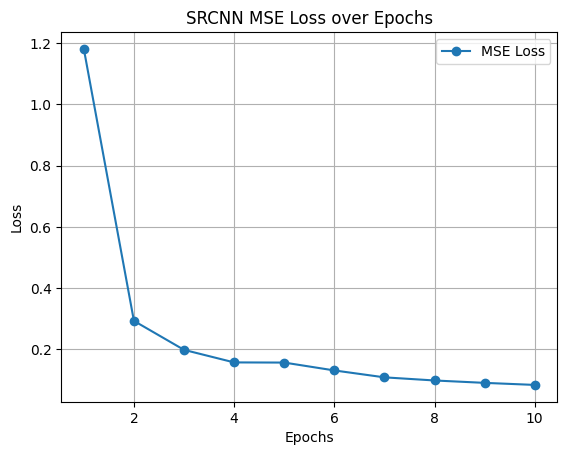

In [9]:
plt.plot(
    range(1, n_epochs + 1), loss_history, 
    label='MSE Loss', marker='o'
)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SRCNN MSE Loss over Epochs')
plt.legend()

plt.grid(True)
plt.show()

# Testing using DIV2K bicubically compressed images

In [20]:
transform_div2k = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [25]:
import torch.nn.functional as F

def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr_value = 20 * torch.log10(1 / torch.sqrt(mse))
    return psnr_value.item()

In [29]:
mse_loss = nn.MSELoss()

In [30]:
class ImageDatasetDIV2K(Dataset):
    def __init__(self, root_dir):
        super(ImageDatasetDIV2K, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "Compressed_X4"))
        files_high = os.listdir(os.path.join(root_dir, "X4"))
        self.data = list(zip(files_low, files_high))
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        
        low_res_pth = os.path.join(self.root_dir, "Compressed_X4", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "X4", img_high_file)

        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]
        
        low_res = transform_div2k(low_res)
        high_res = transform_div2k(high_res)
        
        return low_res, high_res

MSE: 0.010300714522600174, PSNR: 19.871326446533203


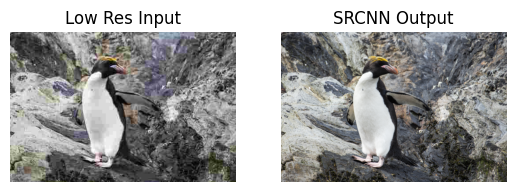

MSE: 0.005373646505177021, PSNR: 22.697311401367188


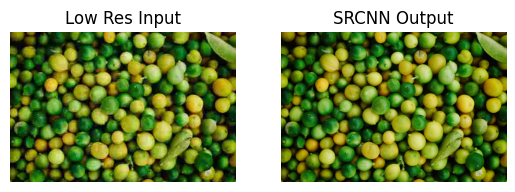

MSE: 0.005515894386917353, PSNR: 22.583839416503906


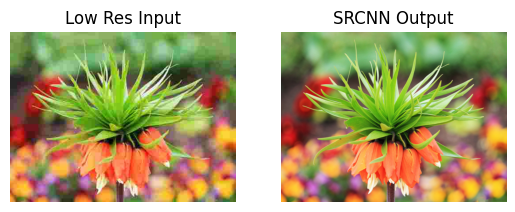

MSE: 0.012457285076379776, PSNR: 19.04576873779297


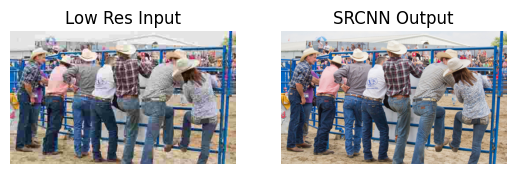

MSE: 0.006641699001193047, PSNR: 21.777210235595703


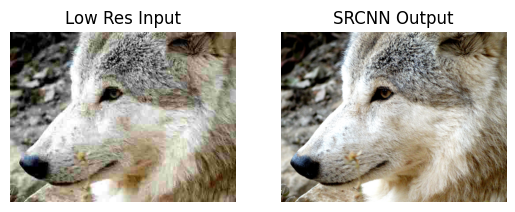

In [72]:
test_data = ImageDatasetDIV2K(root_dir='./DIV2K_valid_LR_bicubic/')

test_images = []

for i in range(5):
    test_images.append((test_data[i][0], test_data[i][1]))

mse_loss = nn.MSELoss()

for i in range(5):
    low_res = test_images[i][0].to(device)
    high_res = test_images[i][1].to(device)

    with torch.no_grad():
        output = model_srcnn(low_res)

    mse_val = mse_loss(high_res, output)
    psnr_val = psnr(high_res, output)

    low_res = low_res.permute(1, 2, 0).cpu().numpy()
    high_res = high_res.permute(1, 2, 0).cpu().numpy()
    output = output.permute(1, 2, 0).cpu().numpy()

    print(f'MSE: {mse_val}, PSNR: {psnr_val}')

    plt.subplot(1, 2, 1)
    plt.imshow(low_res)
    plt.axis('off')  # Turn off axis labels
    plt.title('Low Res Input')

    plt.subplot(1, 2, 2)
    plt.imshow(high_res)
    plt.axis('off')
    plt.title('SRCNN Output')

    plt.show()

# Testing other optimizers and losses

Now let's test some other optimizers and losses. We will try SGD with momentum and Adadelta. As for losses, we will try MAE and Huber loss.

### Adadelta + MSE

In [36]:
torch.cuda.empty_cache()

In [37]:
model = SRCNN().to(device)
optimizer = torch.optim.Adadelta(model.parameters())

In [38]:
n_epochs = 10
writer = SummaryWriter(log_dir='./logs/adadelta')
loss_history = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        adam_optimizer.zero_grad()
        outputs = model_srcnn(inputs)
        loss = mse_loss(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        adam_optimizer.step()

    writer.add_scalar("Loss/train", running_loss, epoch)
    loss_history.append(running_loss)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss:.4f}')
    
writer.flush()
writer.close()

Epoch [1/10], Loss: 0.0841
Epoch [2/10], Loss: 0.0774
Epoch [3/10], Loss: 0.0952
Epoch [4/10], Loss: 0.0684
Epoch [5/10], Loss: 0.0653
Epoch [6/10], Loss: 0.0642
Epoch [7/10], Loss: 0.0625
Epoch [8/10], Loss: 0.0930
Epoch [9/10], Loss: 0.0866
Epoch [10/10], Loss: 0.0594


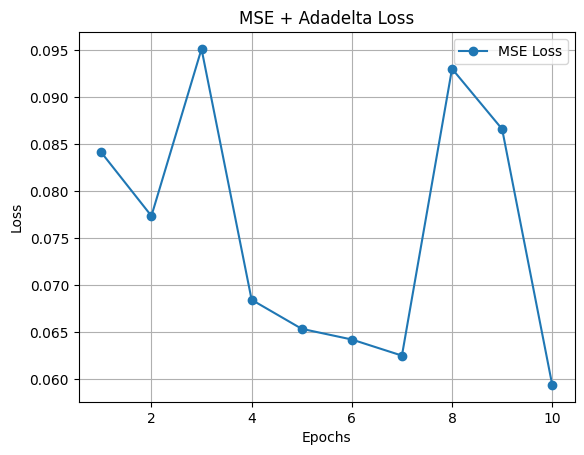

In [39]:
plt.plot(
    range(1, n_epochs + 1), loss_history, 
    label='MSE Loss', marker='o'
)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE + Adadelta Loss')
plt.legend()

plt.grid(True)
plt.show()

## MSE + SGD w/ momentum

In [40]:
torch.cuda.empty_cache()

In [41]:
model = SRCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [42]:
n_epochs = 10
writer = SummaryWriter(log_dir='./logs/sgd')
loss_history = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        adam_optimizer.zero_grad()
        outputs = model_srcnn(inputs)
        loss = mse_loss(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        adam_optimizer.step()

    writer.add_scalar("Loss/train", running_loss, epoch)
    loss_history.append(running_loss)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss:.4f}')
    
writer.flush()
writer.close()

Epoch [1/10], Loss: 0.0612
Epoch [2/10], Loss: 0.0632
Epoch [3/10], Loss: 0.0579
Epoch [4/10], Loss: 0.0566
Epoch [5/10], Loss: 0.0542
Epoch [6/10], Loss: 0.0571
Epoch [7/10], Loss: 0.0568
Epoch [8/10], Loss: 0.0545
Epoch [9/10], Loss: 0.0521
Epoch [10/10], Loss: 0.0522


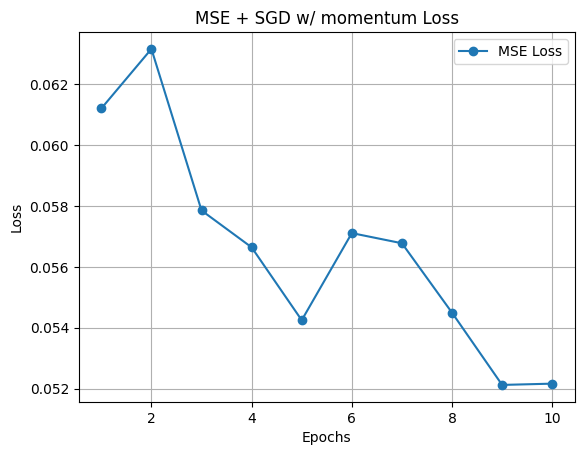

In [43]:
plt.plot(
    range(1, n_epochs + 1), loss_history, 
    label='MSE Loss', marker='o'
)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE + SGD w/ momentum Loss')
plt.legend()

plt.grid(True)
plt.show()

## MAE + SGD

In [51]:
torch.cuda.empty_cache()

In [52]:
model = SRCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mae_loss = nn.L1Loss()

In [53]:
n_epochs = 10
writer = SummaryWriter(log_dir='./logs/mae')
loss_history = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        adam_optimizer.zero_grad()
        outputs = model_srcnn(inputs)
        loss = mse_loss(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        adam_optimizer.step()

    writer.add_scalar("Loss/train", running_loss, epoch)
    loss_history.append(running_loss)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss:.4f}')
    
writer.flush()
writer.close()

Epoch [1/10], Loss: 0.0483
Epoch [2/10], Loss: 0.0479
Epoch [3/10], Loss: 0.0481
Epoch [4/10], Loss: 0.0485
Epoch [5/10], Loss: 0.0498
Epoch [6/10], Loss: 0.0479
Epoch [7/10], Loss: 0.0502
Epoch [8/10], Loss: 0.0715
Epoch [9/10], Loss: 0.0545
Epoch [10/10], Loss: 0.0551


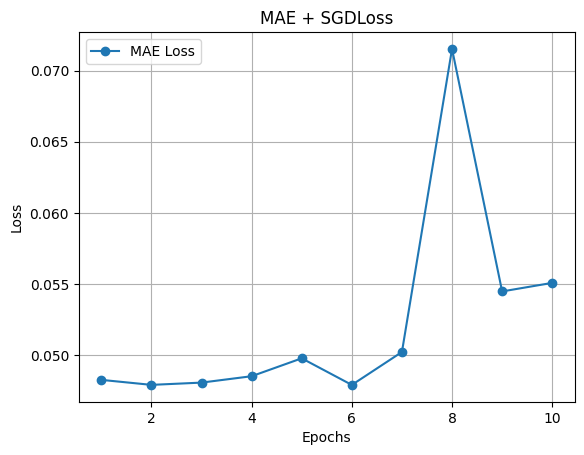

In [54]:
plt.plot(
    range(1, n_epochs + 1), loss_history, 
    label='MAE Loss', marker='o'
)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MAE + SGDLoss')
plt.legend()

plt.grid(True)
plt.show()

## Huber + Adam

In [55]:
torch.cuda.empty_cache()

In [56]:
model = SRCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
mae_loss = nn.HuberLoss()

In [57]:
n_epochs = 10
writer = SummaryWriter(log_dir='./logs/mae')
loss_history = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        adam_optimizer.zero_grad()
        outputs = model_srcnn(inputs)
        loss = mse_loss(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        adam_optimizer.step()

    writer.add_scalar("Loss/train", running_loss, epoch)
    loss_history.append(running_loss)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss:.4f}')
    
writer.flush()
writer.close()

Epoch [1/10], Loss: 0.0526
Epoch [2/10], Loss: 0.0494
Epoch [3/10], Loss: 0.0524
Epoch [4/10], Loss: 0.0506
Epoch [5/10], Loss: 0.0467
Epoch [6/10], Loss: 0.0465
Epoch [7/10], Loss: 0.0477
Epoch [8/10], Loss: 0.0503
Epoch [9/10], Loss: 0.0471
Epoch [10/10], Loss: 0.0524


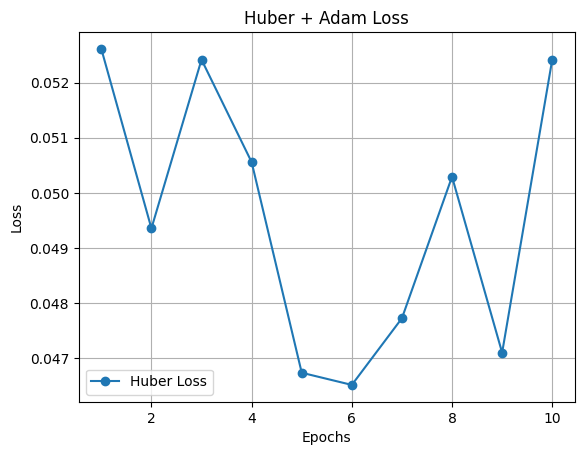

In [58]:
plt.plot(
    range(1, n_epochs + 1), loss_history, 
    label='Huber Loss', marker='o'
)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Huber + Adam Loss')
plt.legend()

plt.grid(True)
plt.show()

# K-fold Cross-Validation

With the basic training loop out of the way, now it's time to perform cross-validation.

In [59]:
num_epochs = 10
batch_size = 16
learning_rate = 0.001
k_folds = 5

In [60]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [61]:
raw_dataset = ImageDatasetSRCNN(root_dir='./dataset/Raw Data/')
raw_list = []

for _, (low_res, high_res) in enumerate(raw_dataset):
    raw_list.append((low_res, high_res))

raw_list[:5]

[(tensor([[[0.0824, 0.0824, 0.0588,  ..., 0.4157, 0.4314, 0.4314],
           [0.0824, 0.0824, 0.0588,  ..., 0.4157, 0.4314, 0.4314],
           [0.0627, 0.0627, 0.0588,  ..., 0.3451, 0.3804, 0.3804],
           ...,
           [0.6157, 0.6157, 0.6235,  ..., 0.6196, 0.6078, 0.6078],
           [0.6118, 0.6118, 0.6196,  ..., 0.6196, 0.6118, 0.6118],
           [0.6118, 0.6118, 0.6196,  ..., 0.6196, 0.6118, 0.6118]],
  
          [[0.1569, 0.1569, 0.1255,  ..., 0.5216, 0.5255, 0.5255],
           [0.1569, 0.1569, 0.1255,  ..., 0.5216, 0.5255, 0.5255],
           [0.1373, 0.1373, 0.1451,  ..., 0.4667, 0.4824, 0.4824],
           ...,
           [0.6549, 0.6549, 0.6588,  ..., 0.6510, 0.6431, 0.6431],
           [0.6510, 0.6510, 0.6549,  ..., 0.6510, 0.6471, 0.6471],
           [0.6510, 0.6510, 0.6549,  ..., 0.6510, 0.6471, 0.6471]],
  
          [[0.0588, 0.0588, 0.0471,  ..., 0.4863, 0.5333, 0.5333],
           [0.0588, 0.0588, 0.0471,  ..., 0.4863, 0.5333, 0.5333],
           [0.0471, 0.

In [63]:
class SuperResDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [65]:
cv_history = {}

for fold, (train_index, val_index) in enumerate(kf.split(raw_list)):
    train_set = SuperResDataset([raw_list[i] for i in train_index])
    val_set = SuperResDataset([raw_list[i] for i in val_index])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = SRCNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    cv_history[f"fold_{fold}"] = {
        "train_loss": [],
        "val_loss": [],
    }
 
    for epoch in range(num_epochs):
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        cv_history[f'fold_{fold}']['train_loss'].append(train_loss)

        with torch.no_grad():
            val_loss = 0.0
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_targets).item()

        
            cv_history[f'fold_{fold}']['val_loss'].append(val_loss)
            print(f'Fold [{fold + 1}/{k_folds}], Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

Fold [1/5], Epoch [1/10], Validation Loss: 0.1315
Fold [1/5], Epoch [2/10], Validation Loss: 0.0810
Fold [1/5], Epoch [3/10], Validation Loss: 0.0503
Fold [1/5], Epoch [4/10], Validation Loss: 0.0384
Fold [1/5], Epoch [5/10], Validation Loss: 0.0369
Fold [1/5], Epoch [6/10], Validation Loss: 0.0280
Fold [1/5], Epoch [7/10], Validation Loss: 0.0258
Fold [1/5], Epoch [8/10], Validation Loss: 0.0243
Fold [1/5], Epoch [9/10], Validation Loss: 0.0221
Fold [1/5], Epoch [10/10], Validation Loss: 0.0209
Fold [2/5], Epoch [1/10], Validation Loss: 0.1758
Fold [2/5], Epoch [2/10], Validation Loss: 0.0709
Fold [2/5], Epoch [3/10], Validation Loss: 0.0506
Fold [2/5], Epoch [4/10], Validation Loss: 0.0412
Fold [2/5], Epoch [5/10], Validation Loss: 0.0375
Fold [2/5], Epoch [6/10], Validation Loss: 0.0310
Fold [2/5], Epoch [7/10], Validation Loss: 0.0254
Fold [2/5], Epoch [8/10], Validation Loss: 0.0237
Fold [2/5], Epoch [9/10], Validation Loss: 0.0282
Fold [2/5], Epoch [10/10], Validation Loss: 0.021

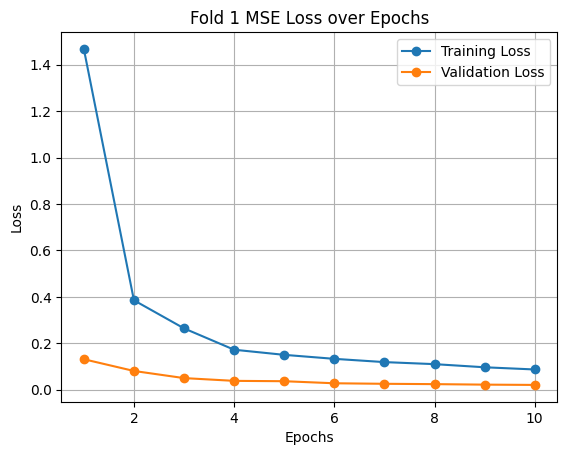

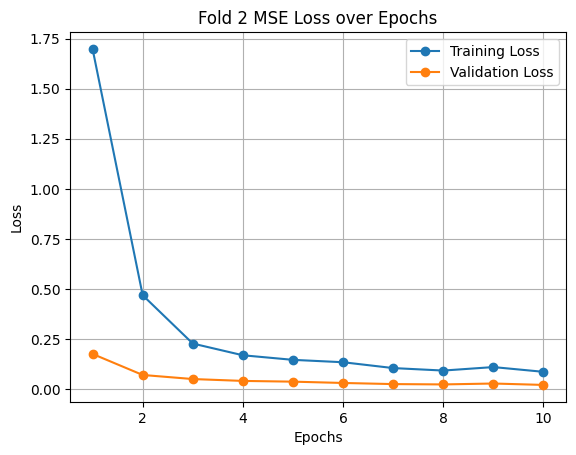

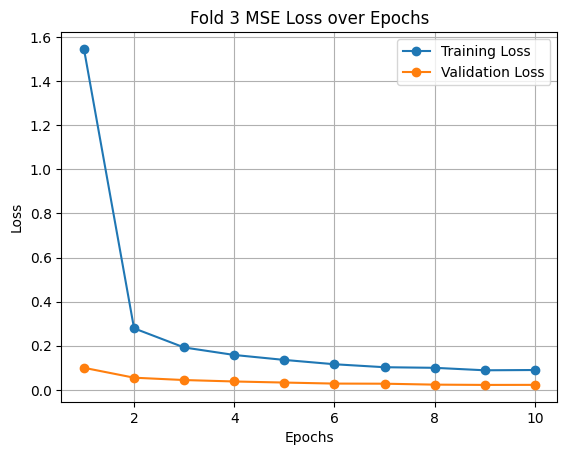

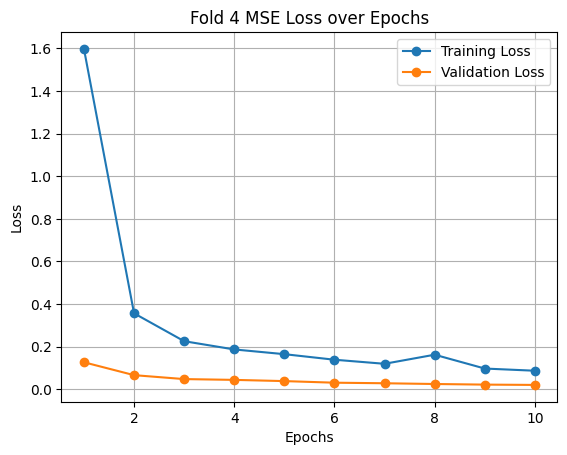

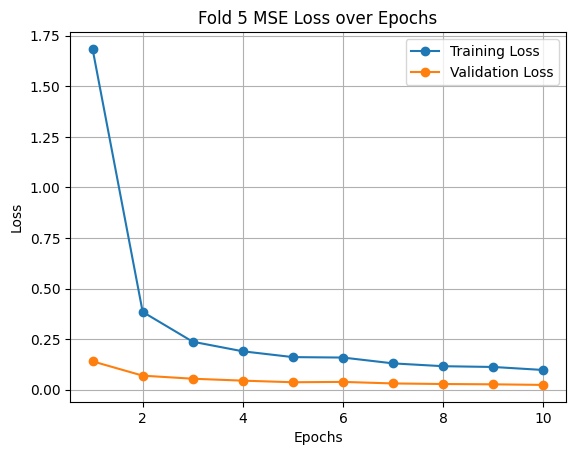

In [66]:
for fold in range(k_folds):
    plt.plot(
        range(1, n_epochs + 1), cv_history[f'fold_{fold}']['train_loss'], 
        label='Training Loss', marker='o'
    )

    plt.plot(
        range(1, n_epochs + 1), cv_history[f'fold_{fold}']['val_loss'], 
        label='Validation Loss', marker='o'
    )

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1} MSE Loss over Epochs')
    plt.legend()

    plt.grid(True)
    plt.show()

# Hyperparameter Tuning

SGD doesn't have a good default learning rate value. Each problem requires us to find the specific `lr` value for SGD that works the best in this scenario. That's why we decided to use SGD for hyperparameter tuning. Other hypeparameters that we can find the optimal values for are `batch_size` and `n_epochs`. We will use `Optuna` for hyperparameter tuning. 

In [67]:
import optuna

In [68]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    num_epochs = trial.suggest_int('num_epochs', 5, 20)

    model = SRCNN().to(device)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_dataset = ImageDatasetSRCNN(root_dir='./dataset/train/')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = ImageDatasetSRCNN(root_dir='./dataset/val')
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        val_loss = 0.0
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    return val_loss

In [70]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-01-25 23:27:28,659] A new study created in memory with name: no-name-6ab9270f-6d00-4027-b9a9-3d14fd666afc
C:\Users\vladi\AppData\Local\Temp\ipykernel_19572\2827497761.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-01-25 23:35:14,688] Trial 0 finished with value: 0.21716762334108353 and parameters: {'learning_rate': 4.231445724359183e-05, 'batch_size': 16, 'num_epochs': 13}. Best is trial 0 with value: 0.21716762334108353.
[I 2024-01-25 23:40:45,675] Trial 1 finished with value: 0.12134857289493084 and parameters: {'learning_rate': 0.00021175614453135453, 'batch_size': 32, 'num_epochs': 9}. Best is trial 1 with value: 0.12134857289493084.
[I 2024-01-25 23:49:11,489] Trial 2 finished with value: 0.4182720361277461 and parameters: {'learning

In [71]:
print('Best hyperparameters:', study.best_params)

Best hyperparameters: {'learning_rate': 0.006550195670178802, 'batch_size': 32, 'num_epochs': 10}
